In [1]:
import logging
import os
import time

import pandas as pd
import plotly.express as px
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

import collab.foraging.toolkit as ftk

smoke_test = "CI" in os.environ

num_svi_iters = 400 if not smoke_test else 4
num_samples = 1000 if not smoke_test else 10

In [2]:
# load data
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = ftk.rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = ftk.subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=121
)

# create a test foragers object with 20 frames
num_frames = 10
foragers_object = ftk.dataObject(
    fishDF_scaled_subsampled.loc[fishDF_scaled_subsampled["time"] < num_frames],
    grid_size=grid_size,
)

original_frames: 18739
original_shape: (74956, 5)
resulting_frames: 155
resulting_shape: (620, 5)


/Users/palka/Documents/Repositories/collab-creatures/collab/foraging/toolkit/utils.py:42: UserWarning: 
                NaN values in data. The default behavior of predictor/score generating functions is
                to ignore foragers with missing positional data. To modify, see documentation of
                `derive_predictors_and_scores` and `generate_local_windows`
                
  warnings.warn(


In [3]:
# derive predictors

local_windows_kwargs = {
    "window_size": 15,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}

predictor_kwargs = {
    "vicsek": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "dt": 1,
        "sigma_v": 3,
        "sigma_t": 0.3,
    },
    "vicsek_large_sigma": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "dt": 1,
        "sigma_v": 10,
        "sigma_t": 1,
    },
    "pairwiseCopying": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "dt": 1,
        "sigma_v": 3,
        "sigma_t": 0.3,
    },
    "proximity": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "repulsion_radius": 1.5,
        "optimal_distance": 4,
        "proximity_decay": 1,
    },
}

score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

derivedDF = ftk.derive_predictors_and_scores(
    foragers_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

2024-12-11 19:43:20,933 - Local windows completed in 0.34 seconds.
2024-12-11 19:43:21,483 - vicsek completed in 0.55 seconds.
2024-12-11 19:43:21,989 - vicsek_large_sigma completed in 0.50 seconds.
2024-12-11 19:43:22,923 - pairwiseCopying completed in 0.93 seconds.
2024-12-11 19:43:23,572 - proximity completed in 0.65 seconds.
2024-12-11 19:43:23,686 - nextStep_linear completed in 0.11 seconds.
2024-12-11 19:43:23,810 - nextStep_sublinear completed in 0.12 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 8277/25075 (~33.01%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-12-11 19:43:23,905 - de

In [4]:
display(derivedDF)

,vicsek,vicsek_large_sigma,pairwiseCopying,proximity,nextStep_linear,nextStep_sublinear,vicsek_scaled,vicsek_large_sigma_scaled,pairwiseCopying_scaled,proximity_scaled,nextStep_linear_scaled,nextStep_sublinear_scaled
969,2.333703e-25,0.006069,2.015709e-11,0.000072,0.125000,0.064586,0.021856,0.022002,0.136897,0.130780,0.189130,0.189204
1014,9.256047e-21,0.015739,8.391062e-14,0.000009,0.129476,0.066981,0.114302,0.115693,0.084757,0.050869,0.197826,0.197928
1015,2.267917e-21,0.013868,2.174845e-13,0.000018,0.149908,0.077996,0.100863,0.102215,0.091555,0.069629,0.229891,0.230098
1016,4.450581e-22,0.011977,1.117982e-12,0.000034,0.166146,0.086844,0.085443,0.086478,0.105962,0.093320,0.258152,0.257906
1017,7.065420e-23,0.010149,5.522924e-12,0.000061,0.177941,0.093325,0.068044,0.068775,0.122552,0.122362,0.275543,0.275354
...,...,...,...,...,...,...,...,...,...,...,...,...
2426,6.896891e-06,0.343146,7.092926e-05,0.000055,0.045359,0.022942,0.615080,0.627131,0.461145,0.115688,0.055435,0.055616
2427,3.240315e-06,0.320592,5.465289e-05,0.000049,0.042124,0.021289,0.595063,0.606805,0.449295,0.111719,0.051087,0.051254
2428,1.320367e-06,0.295708,3.876775e-05,0.000041,0.036758,0.018551,0.573278,0.584438,0.436822,0.102159,0.041848,0.041985
2429,4.706635e-07,0.269491,2.563767e-05,0.000032,0.029295,0.014756,0.546612,0.557774,0.419858,0.090915,0.029891,0.029989


# Try inference pipeline

In [5]:
# convert predictors and scores to tensors
vicsek = torch.tensor(derivedDF["vicsek"].values)
pCopying = torch.tensor(derivedDF["pairwiseCopying"].values)
score = torch.tensor(derivedDF["nextStep_linear"].values)

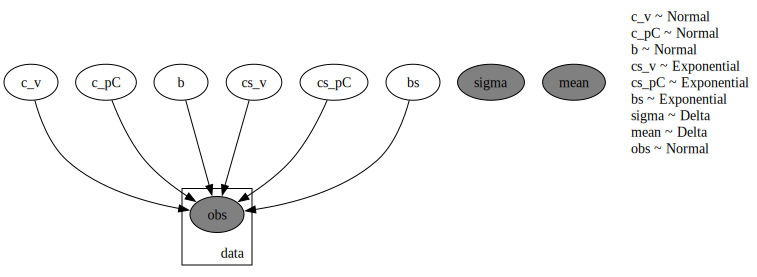

In [6]:
# define the probabilistic model using pyro (https://pyro.ai/)
# c_v, c_pC, b are the coefficients
# for vicsek, pairwiseCopying and the intercept

# cs_v, cs_pC, bs are analogous coefficients,
# but they contribute to the variance,
# which is not assumed to remain fixed


def model_sigmavar(vicsek, pCopying, score):
    c_v = pyro.sample("c_v", dist.Normal(0, 0.2))
    c_pC = pyro.sample("c_pC", dist.Normal(0, 0.2))
    b = pyro.sample("b", dist.Normal(0.5, 0.3))

    cs_v = pyro.sample("cs_v", dist.Exponential(7))
    cs_pC = pyro.sample("cs_pC", dist.Exponential(7))
    bs = pyro.sample("bs", dist.Exponential(7))

    sigma = pyro.deterministic("sigma", bs + cs_v * vicsek + cs_pC * pCopying)
    mean = pyro.deterministic("mean", b + c_v * vicsek + c_pC * pCopying)

    with pyro.plate("data", len(score)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=score)


pyro.render_model(
    model_sigmavar,
    model_args=(vicsek, pCopying, score),
    render_distributions=True,
)

In [7]:
def summary(samples, sites):
    site_stats = {}
    for site_name, values in samples.items():
        if site_name in sites:
            marginal_site = pd.DataFrame(values)
            describe = marginal_site.describe(
                percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]
            ).transpose()
            site_stats[site_name] = describe[
                ["mean", "std", "5%", "25%", "50%", "75%", "95%"]
            ]
    return site_stats


def get_samples(
    vicsek,
    pCopying,
    score,
    model=model_sigmavar,
    num_svi_iters=num_svi_iters,
    num_samples=num_samples,
):
    guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
    svi = SVI(model_sigmavar, guide, optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

    iterations = []
    losses = []

    logging.info(f"Starting SVI inference with {num_svi_iters} iterations.")
    start_time = time.time()
    pyro.clear_param_store()
    for i in range(num_svi_iters):
        elbo = svi.step(vicsek, pCopying, score)
        iterations.append(i)
        losses.append(elbo)
        if i % 200 == 0:
            logging.info("Elbo loss: {}".format(elbo))
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info("SVI inference completed in %.2f seconds.", elapsed_time)

    fig = px.line(x=iterations, y=losses, title="ELBO loss", template="presentation")
    labels = {"iterations": "iteration", "losses": "loss"}
    fig.update_xaxes(showgrid=False, title_text=labels["iterations"])
    fig.update_yaxes(showgrid=False, title_text=labels["losses"])
    fig.update_layout(width=700)
    fig.show()

    predictive = Predictive(
        model, guide=guide, num_samples=num_samples, return_sites=["c_v", "c_pC"]
    )
    test_svi = {
        k: v.flatten().reshape(num_samples, -1).detach().cpu().numpy()
        for k, v in predictive(vicsek, pCopying, score).items()
        if k != "obs"
    }

    print("SVI-based coefficient marginals:")
    for site, values in summary(test_svi, ["c_v", "c_pC"]).items():
        print("Site: {}".format(site))
        print(values, "\n")

    return {"svi_samples": test_svi, "svi_guide": guide, "svi_predictive": predictive}


def calculate_R_squared(guide):
    predictive = pyro.infer.Predictive(model_sigmavar, guide=guide, num_samples=1000)
    predictions = predictive(vicsek, pCopying, score)

    simulated_outcome = (
        predictions["b"] + predictions["c_v"] * vicsek + predictions["c_pC"] * pCopying
    )

    mean_sim_outcome = simulated_outcome.mean(0).detach().cpu().numpy()

    observed_mean = torch.mean(score)

    tss = torch.sum((score - observed_mean) ** 2)
    rss = torch.sum((score - mean_sim_outcome) ** 2)

    r_squared = 1 - (rss / tss)

    return r_squared.float().item()

In [8]:
samples_test = get_samples(vicsek, pCopying, score)

2024-12-11 19:43:25,905 - Starting SVI inference with 400 iterations.
2024-12-11 19:43:25,988 - Elbo loss: 6797.653677884113
2024-12-11 19:43:28,807 - Elbo loss: -2176.584490240063
2024-12-11 19:43:31,709 - SVI inference completed in 5.80 seconds.


SVI-based coefficient marginals:
Site: c_v
       mean       std        5%       25%       50%       75%       95%
0  0.114179  0.054717  0.023545  0.079086  0.114499  0.153265  0.202425 

Site: c_pC
       mean       std        5%       25%       50%       75%       95%
0  0.562807  0.050745  0.482183  0.529089  0.562317  0.596155  0.648631 



In [9]:
print(
    samples_test.keys()
)  # plot the inferred posterior distributions of the coefficients
# Note that the model infers that the random foragers have
# near-zero coefficients for food trace and proximity score.
# The non-zero coefficient for visibility is consistent with the
# fact that the random foragers are mostly likely to move to nearby
# locations (higher visibility score) compared to farther locations.
ftk.plot_coefs(
    samples_test["svi_samples"],
    "Test fish data",
    nbins=120,
    ann_start_y=160,
    ann_break_y=50,
)

dict_keys(['svi_samples', 'svi_guide', 'svi_predictive'])
